# Example 6b: Angular redistribution matrix method

In [Example 6a](6a-multiscale_models.ipynb), we looked at a silicon heterojunction cell using integrated ray-tracing and TMM to calculate the optical behaviour of each surface, and using the angular redistribution matrix method (ARMM) to combine the surfaces and calculate overall reflection, transmission, absorption per layer and absorption profiles. However, ARMM is not limited to treating surfaces with ray-tracing; it is also possible to use the TMM by itself (for planar layers), RCWA (for gratings/periodic structutes)
or ideal analytic cases (perfect mirrors and Lambertian reflectors are currently implemented) to generate the angular redistribution matrices. In this example we will replicate simulation results shown in the paper on [OPTOS](https://doi.org/10.1364/OE.23.0A1720), looking at the effect of planar surfaces, regular pyramids, and a diffraction grating on absorption in a silicon wafer.

In [275]:
import numpy as np
import os

from solcore.structure import Layer
from solcore import material, si

from rayflare.structure import Interface, BulkLayer, Structure
from rayflare.matrix_formalism import process_structure, calculate_RAT, get_savepath
from rayflare.transfer_matrix_method import tmm_structure
from rayflare.angles import theta_summary, make_angle_vector
from rayflare.textures import regular_pyramids
from rayflare.options import default_options

import matplotlib.pyplot as plt
from sparse import load_npz
import seaborn as sns
import matplotlib as mpl

## Setting up

We have encountered most of these options in the previous examples. Previously, we have mostly simulated optical behaviour for light at normal incidence but in this case, to match the results from the OPTOS paper, we will look at an incidence angle of 8$^\circ$. Other relevant options are `c_azimuth`, which controls how fine the spacing of the angular bins in the azimuthal directions is, and `pol`, the polarization of the incident light.

In [276]:
angle_degrees_in = 8

wavelengths = np.linspace(900, 1180, 30)*1e-9

Si = material('Si')()
Air = material('Air')()

options = default_options()
options.wavelengths = wavelengths
options.theta_in = angle_degrees_in*np.pi/180
options.n_theta_bins = 50
options.c_azimuth = 0.25
options.n_rays = 200000 # increase to reduce noise, decrease for faster execution
options.project_name = 'compare_surfaces'
options.phi_symmetry = np.pi/2
options.I_thresh = 0.005
options.nx = 5
options.ny = 5
options.bulk_profile = False

## Structures and Interfaces

We will consider three structures:

1. Planar front, crossed grating (Si/air) at rear
2. Regular pyramids on the front, planar rear
3. Regular pyramids on the front, crossed grating at rear.

This means we have four different surfaces to consider across all structures:
a. Planar front
b. Pyramidal front
c. Planar rear
d. Grating rear

For structure 1 (a + d), we define the grating (surface d) in the same we would if using `rcwa_structure` ([Example 5a](5a-ultrathin_GaAs_cell.ipynb)). The grating period in this case is 1000 nm with a feature height of 120 nm.

In [277]:
x = 1000

d_vectors = ((x, 0),(0,x))
area_fill_factor = 0.36
hw = np.sqrt(area_fill_factor)*500

front_materials = []
back_materials = [Layer(si('120nm'), Si, geometry=[{'type': 'rectangle', 'mat': Air, 'center': (x/2, x/2),
                                                     'halfwidths': (hw, hw), 'angle': 45}])]

Create the texture for the pyramidal front surface (b):

In [278]:
surf = regular_pyramids(elevation_angle=55, upright=False)

Now we define the four `Interface`s we need for the three `Structure`s; using the numbering above, that is:

- Structure 1 = a + d
- Structure 2 = b + c
- Structure 3 = b + d

For each Interface, we have to specify the method we want to use, a name, the surface layers (or lack therof). For the RT (ray-tracing) surfaces, we need to specify the `texture` and for the RCWA surfaces we need to specify the unit cell lattice vectors `d_vectors` and the number of `rcwa_orders` to use. We also define the bulk, 200 $\mu$m of Si.

In [279]:
front_surf_pyramids = Interface('RT_Fresnel', texture=surf, layers=[],
                                name = 'inv_pyramids_front_' + str(options['n_rays']))
front_surf_planar = Interface('TMM', layers=[], name='planar_front')
back_surf_grating = Interface('RCWA', layers=back_materials, name='crossed_grating_back',
                              d_vectors=d_vectors, rcwa_orders=15) # increase orders for betting convergence (calculation takes longer!)
back_surf_planar = Interface('TMM', layers=[], name = 'planar_back')

bulk_Si = BulkLayer(200e-6, Si, name = 'Si_bulk') # bulk thickness in m

Now we define the three structures listed above. For reference, we also define a fully planar structure (a + c).

In [280]:
SC_fig6 = Structure([front_surf_planar, bulk_Si, back_surf_grating], incidence=Air, transmission=Air)
SC_fig7 = Structure([front_surf_pyramids, bulk_Si, back_surf_planar], incidence=Air, transmission=Air)
SC_fig8 = Structure([front_surf_pyramids, bulk_Si, back_surf_grating], incidence=Air, transmission=Air)
planar = Structure([front_surf_planar, bulk_Si, back_surf_planar], incidence=Air, transmission=Air)

Now, as in [Example 6a](6a-multiscale_models.ipynb), we process the structures (to generate the matrices) and then use `calculate_rat` to obtain the final results. Note that it is not necessary to call `process_structure` for the planar structure, because the redistribution matrices for both of its interfaces will have already been calculated when considering structures 1 and 2.

In [281]:
#| output: false

# Process structures (step 1)

process_structure(SC_fig6, options, save_location="current")
process_structure(SC_fig7, options, save_location="current")
process_structure(SC_fig8, options, save_location="current")

# Calculate RAT (step 2)

results_fig6= calculate_RAT(SC_fig6, options, save_location="current")
results_fig7 = calculate_RAT(SC_fig7, options, save_location="current")
results_fig8 = calculate_RAT(SC_fig8, options, save_location="current")
results_planar = calculate_RAT(planar, options, save_location="current")

# Get RAT results
RAT_fig6 = results_fig6[0]
RAT_fig7 = results_fig7[0]
RAT_fig8 = results_fig8[0]

RAT_planar = results_planar[0]

Making matrix for planar surface using TMM for element 0 in structure
Existing angular redistribution matrices found
Existing angular redistribution matrices found
RCWA calculation for element 2 in structure
Existing angular redistribution matrices found
Ray tracing with Fresnel equations for element 0 in structure
Existing angular redistribution matrices found
Existing angular redistribution matrices found
Making matrix for planar surface using TMM for element 2 in structure
Existing angular redistribution matrices found
Ray tracing with Fresnel equations for element 0 in structure
Existing angular redistribution matrices found
Existing angular redistribution matrices found
RCWA calculation for element 2 in structure
Existing angular redistribution matrices found
b
After iteration 1 : maximum power fraction remaining = 0.3047168563382379
After iteration 2 : maximum power fraction remaining = 0.265018080742631
After iteration 3 : maximum power fraction remaining = 0.23964061503063333
A

Of course, it is not necessary to use the ARMM to calculate the optics of a simple planar slab of Si; we could have done this simply with an (incoherent) TMM calculation. We will do this to compare the results:

In [282]:
struc = tmm_structure([Layer(si('200um'), Si)], Air, Air)
options.coherent = False
options.coherency_list = ['i']
RAT = tmm_structure.calculate(struc, options)

## Results

**PLOT 1**: Absorption in Si for the four different structures.

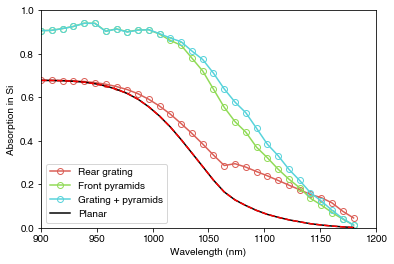

In [283]:
palhf = sns.color_palette("hls", 4)

fig = plt.figure()
plt.plot(wavelengths*1e9, RAT_fig6['A_bulk'][0], '-o', color=palhf[0], label='Rear grating', fillstyle='none')
plt.plot(wavelengths*1e9, RAT_fig7['A_bulk'][0], '-o', color=palhf[1],  label= 'Front pyramids', fillstyle='none')
plt.plot(wavelengths*1e9, RAT_fig8['A_bulk'][0], '-o', color=palhf[2],  label= 'Grating + pyramids', fillstyle='none')
plt.plot(wavelengths*1e9, RAT['A_per_layer'][:,0], '-k', label='Planar')
plt.plot(wavelengths*1e9, RAT_planar['A_bulk'][0], '--r')
plt.legend(loc='lower left')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorption in Si')
plt.xlim([900, 1200])
plt.ylim([0, 1])
plt.show()

We can see that both the rear grating and front surface pyramid texture increase absorption in the Si. The rear grating does not affect the front surface reflection, while the pyramid texture does, which increases absorption over the whole wavelength range. The two methods for calculating absorption in the planar structure are in agreement as expected.

## Visualizing the redistribution matrices

RayFlare has built-in functions to make it easier to load and plot the redistribution matrices you have generated. First, based on the options we set, we generate the `angle_vector` which lists the $\theta$ (polar angle) and $\phi$ (azimuthal angle) values in each bin of the angular redistribution matrices.

In [284]:
theta_intv, phi_intv, angle_vector = make_angle_vector(options['n_theta_bins'], options['phi_symmetry'],
                                       options['c_azimuth'])

palhf = sns.cubehelix_palette(256, start=.5, rot=-.9)
palhf.reverse()
seamap = mpl.colors.ListedColormap(palhf)

Now we find the `path` where the matrices are stored. We calculated the redistribution matrices at different wavelengths, but we are just going to plot them at a single wavelength, so we find which index in the matrix that wavelength corresponds to.

In [285]:
path = get_savepath('current', options.project_name)

wl_to_plot = 1100e-9

wl_index = np.argmin(np.abs(wavelengths-wl_to_plot))

The redistribution matrices are stored in a sparse matrix format (this is much more efficient, since usually many matrix entries will be zero. A sparse matrix format lists only the non-zero entries). Using the  `path` we found above and the name of the surface, we load the sparse matrix, select only the wavelength we are interested in, and convert it to a normal NumPy array (a "dense" matrix):

In [286]:
sprs = load_npz(os.path.join(path, SC_fig8[2].name + 'frontRT.npz'))
# Load the redistribution matrices for the bottom surface in SC_fig8 (this is the grating)

full = sprs[wl_index].todense()
# Convert from sparse format to normal numpy array

The indexing of the sparse array is (wavelength, angular bin out, angular bin in). To make the information easier to interpret, RayFlare has the `theta_summary` function which will sum over all the azimuthal bins at a certain $\theta$, and returns the results in [xarray format](https://docs.xarray.dev). We then select only the first half of the matrix; the data for reflection and transmission are stored in the same array (0 to $2 \pi$ radians), but we pick out only the reflection part.

In [287]:
summat = theta_summary(full, angle_vector, options['n_theta_bins'], front_or_rear='front')
# Front or rear refers to front or rear incidence on the surface, rather than the front or rear surface of the
# whole structure

summat_g = summat[:options['n_theta_bins'], :]
# We select the FIRST half of the matrix: this is redistribution into the upper half plane, so because we are
# looking at incident light coming from this half-plane, this corresponds to reflection

We can use xarray's functionality to transform the coordinates from $\theta$ to $\sin\theta$, and then rename the coordinates (this will automatically label the plots below).

In [288]:
summat_g = summat_g.assign_coords({r'$\theta_{in}$': np.sin(summat_g.coords[r'$\theta_{in}$']).data,
                                    r'$\theta_{out}$': np.sin(summat_g.coords[r'$\theta_{out}$']).data})

summat_g = summat_g.rename({r'$\theta_{in}$': r'$\sin(\theta_{in})$', r'$\theta_{out}$': r'$\sin(\theta_{out})$'})

Now repeat this for another surface (the pyramidal surface):

In [289]:
sprs = load_npz(os.path.join(path, SC_fig8[0].name + 'rearRT.npz'))
# Load the redistribution matrices for the top surface in SC_fig8 (this is the pyramids)

full = sprs[wl_index].todense()

summat = theta_summary(full, angle_vector, options['n_theta_bins'], front_or_rear='rear')
# Front or rear refers to front or rear incidence on the surface, rather than the front or rear surface of the
# whole structure

summat_r = summat[options['n_theta_bins']:, :]
# We select the SECOND half of the matrix: this is redistribution into the lower half plane, so because we are
# looking at incident light coming from this half-plane, this corresponds to reflection

summat_r = summat_r.assign_coords({r'$\theta_{in}$': np.sin(summat_r.coords[r'$\theta_{in}$']).data,
                                    r'$\theta_{out}$': np.sin(summat_r.coords[r'$\theta_{out}$']).data})

summat_r = summat_r.rename({r'$\theta_{in}$': r'$\sin(\theta_{in})$', r'$\theta_{out}$': r'$\sin(\theta_{out})$'})

Plot the redistribution matrices:

**PLOT 2**: Redistribution matrices for reflection into Silicon from the diffraction grating (left) and pyramid surface (right).

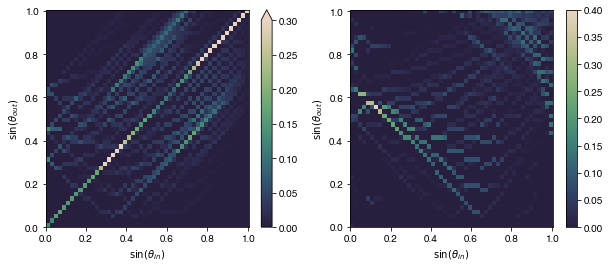

In [290]:
fig = plt.figure(figsize=(10,4))
ax = plt.subplot(121)
ax = summat_g.plot.imshow(ax=ax, cmap=seamap, vmax=0.3)
ax = plt.subplot(122)
ax = summat_r.plot.imshow(ax=ax, cmap=seamap)
plt.show()

The left plot shows redistribution of light upon reflection from the rear grating. The right plot shows redistribution of light which hits the pyramidal front surface *from the inside* and is reflected back into the cell. We could plot equivalent matrices for e.g. transmission through the rear grating or light escaping when incident on the pyramid surface from the inside of the structure.